In [1]:
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import model_from_json
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [2]:
# load json and create model
json_file = open('model_hourly_v1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_hourly_v1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
loaded_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Loaded model from disk


In [3]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
import csv
time_step = []
temps = []

with open('./timeseries_hourly.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps).astype("float64")
time = np.array(time_step).astype("float64")
time = time[60000:]
series = series[60000:]
time = time-60000
series[series>75] = 75

In [6]:
window_size = 7*24
batch_size = 52
shuffle_buffer_size = 1000

split_time = 24000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
rnn_forecast = model_forecast(loaded_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at <ipython-input-3-396ca7f16d87>:6) ]] [Op:__inference_distributed_function_1099]

Function call stack:
distributed_function


In [8]:
import numpy as np
np.mean(np.sqrt(np.square(x_valid-rnn_forecast)))

NameError: name 'rnn_forecast' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
start = 40 + 24*7*18
show_length = 24*7
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [36]:
predict_size=24*7 + 24*1 + 8
test = x_valid[0:predict_size]

In [37]:
for i in range(predict_size):
    test = test.reshape(1,predict_size,1)
    forecast = loaded_model.predict(test)
    test = np.concatenate([test[0][1:], np.array(forecast[0][-1]).reshape([1,1])], axis=0)

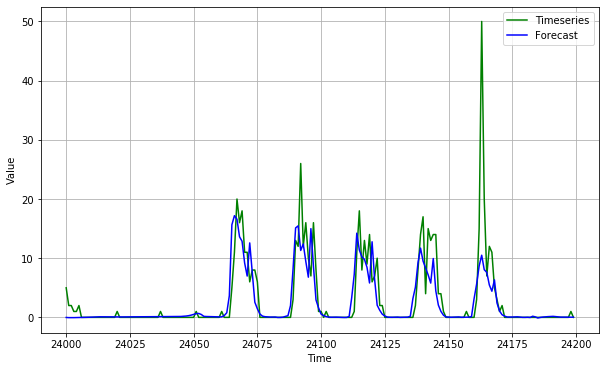

In [38]:
plt.figure(figsize=(10, 6))
start = 0
show_length = predict_size
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], test[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [ ]:
84000 

In [39]:
24*7 + 24*1 + 8

200

In [40]:
import pandas as pd
date = pd.read_csv("date_hourly.csv")
date = date[60000:]
date.drop("Unnamed: 0", inplace=True, axis=1)

In [42]:
predict_size= -(-111 - 24*7)
df = pd.DataFrame([date["Date"].iloc[-predict_size:].values, rnn_forecast[-predict_size:]]).T
df.columns = ["date", "value"]
df.to_csv("Plot_hourly.csv")

In [ ]:
#2016-11-19 13:00:00

In [ ]:
#Anfang  #2019-07-24 08:00:00

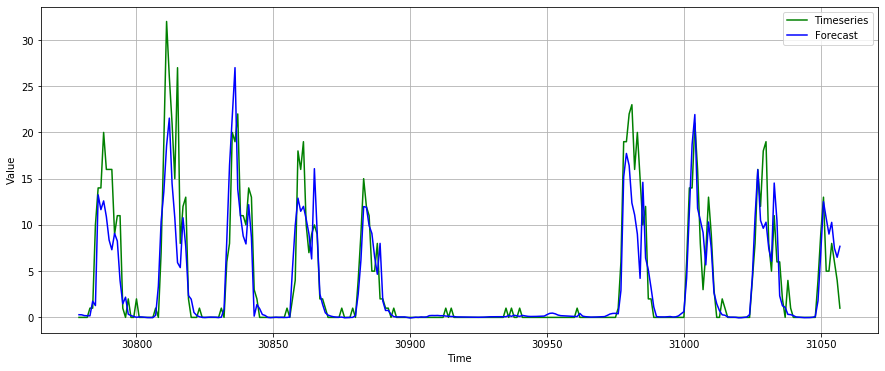

In [65]:
plt.figure(figsize=(15, 6))
start_from_end = -111 - 24*7
show_length = predict_size
plot_series(time_valid[start_from_end:], x_valid[start_from_end:],'g')
plot_series(time_valid[start_from_end:], rnn_forecast[start_from_end:],'b')
plt.legend(["Timeseries","Forecast","Error"])

In [69]:
predict_size= -(-111 - 24*7)
test = x_valid[-predict_size:]

In [70]:
for i in range(predict_size):
    test = test.reshape(1,predict_size,1)
    forecast = loaded_model.predict(test)
    test = np.concatenate([test[0][1:], np.array(forecast[0][-1]).reshape([1,1])], axis=0)

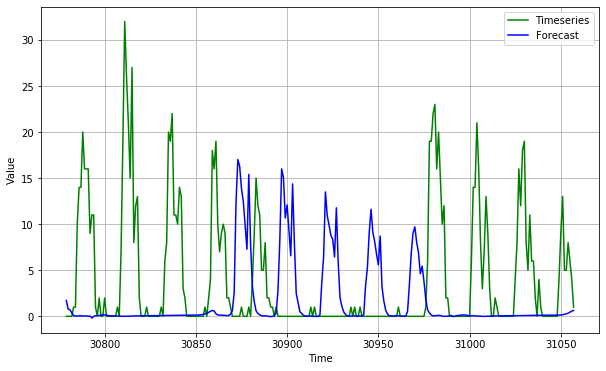

In [72]:
plt.figure(figsize=(10, 6))
start = 0
show_length = predict_size
plot_series(time_valid[-predict_size:], x_valid[-predict_size:],'g')
plot_series(time_valid[-predict_size:], test,'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)